In [103]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.optimize as sopt

plt.rcParams["figure.figsize"] = (6,3)

# Data science & Python & Machine Learning

### Машинное обучение: ранжирование, ближайший сосед, кластеризация и векторные модели

### Поиск параметров

- Самый простой подход - перебор всех возможных параметров по сетке: GridSearch
- В ограниченном времени эффективнее RandomizedSearch

In [207]:
from sklearn.model_selection import ParameterGrid

parameters = {'n_estimators': [10, 20, 50, 200], 'max_depth': [3, 5, 7]}
list(ParameterGrid(parameters))

[{'max_depth': 3, 'n_estimators': 10},
 {'max_depth': 3, 'n_estimators': 20},
 {'max_depth': 3, 'n_estimators': 50},
 {'max_depth': 3, 'n_estimators': 200},
 {'max_depth': 5, 'n_estimators': 10},
 {'max_depth': 5, 'n_estimators': 20},
 {'max_depth': 5, 'n_estimators': 50},
 {'max_depth': 5, 'n_estimators': 200},
 {'max_depth': 7, 'n_estimators': 10},
 {'max_depth': 7, 'n_estimators': 20},
 {'max_depth': 7, 'n_estimators': 50},
 {'max_depth': 7, 'n_estimators': 200}]

### Поиск параметров


In [209]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
RandomizedSearchCV(rf, parameters)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [10, 20, 50, 200], 'max_depth': [3, 5, 7]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [211]:
df = pd.read_csv('cs-training.csv', index_col=0).fillna(-1)
from sklearn.ensemble import GradientBoostingClassifier
rf = GradientBoostingClassifier()
x = df.drop(columns='SeriousDlqin2yrs')
y = df['SeriousDlqin2yrs']
rf.fit(x, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

### Ансамбли деревьев решений

- Random Forest как правило требует бóльшей глубины деревьев
- Бустинг строится итеративно, поэтому каждая модель может быть проще

In [213]:
pd.DataFrame(list(zip(x.columns, rf.feature_importances_)))

,0,1
0,RevolvingUtilizationOfUnsecuredLines,0.193476
1,age,0.108346
2,NumberOfTime30-59DaysPastDueNotWorse,0.096686
3,DebtRatio,0.125796
4,MonthlyIncome,0.073407
5,NumberOfOpenCreditLinesAndLoans,0.074801
6,NumberOfTimes90DaysLate,0.168856
7,NumberRealEstateLoansOrLines,0.050909
8,NumberOfTime60-89DaysPastDueNotWorse,0.086806
9,NumberOfDependents,0.020917


### Сохранение и загрузка модели

In [214]:
import pickle
pickle.dump(rf, open('model.pickle', 'wb'))
rf2 = pickle.load(open('model.pickle', 'rb'))
rf2.predict(x)

array([0, 0, 0, ..., 0, 0, 0])

### Ранжирование

- Фактически, задача регрессии
- Отличается лишь функция потерь
- Почти любой классификатор уже умеет ранжировать

In [215]:
df['Prediction'] = rf.predict_proba(x)[:, 1]
df.sort_values(by='Prediction', ascending=False).head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Prediction
68562,1,0.025838,69,0,0.001141,7009.0,3,0,0,0,0.0,0.998497
39589,1,0.115114,72,0,0.019952,5813.0,6,0,0,0,0.0,0.988603
9017,1,0.114584,61,0,0.220978,10000.0,11,0,1,0,0.0,0.944463
107594,1,0.963327,49,6,1.726819,6416.0,15,2,8,3,0.0,0.937448
68538,1,0.908082,26,3,1.444855,6500.0,22,1,4,8,0.0,0.936008


### Ранжирование на практике

- Самое простое - обучаться классификации, а использовать вероятности
- Иногда данные представлены парами (лучше - хуже). Тогда нужно использовать алгоритм, который умеет это использовать, например CatBoost
- В ранжировании есть свои метрики: NDCG, ... - все *сложнее*

### Несбалансированные задачи

- В некоторых задачах количество положительных примеров сильно меньше, чем отрицательных
- С этим что-то нужно делать, но прежде всего измерять
- Доля правильно угаданных классов - плохая метрика

### Confusion matrix

- Назовем один класс Positive, а другой Negative
- Тогда можно определить True Positive, True Negative, False Negative, False Positive

In [216]:
from sklearn.metrics import confusion_matrix
p = rf.predict(x)
confusion_matrix(y, p)

array([[138666,   1308],
       [  7921,   2105]])

### Precision, recall, F1

- $p = \mathsf{Precision} = \frac{\mathsf{TP}}{\mathsf{FP} + \mathsf{TP}}$
- $r = \mathsf{Recall} = \frac{\mathsf{TP}}{\mathsf{FN} + \mathsf{TP}}$
- Метрики противоречат друг другу
- Баланс даёт $\mathsf{F}_1 = \frac{2 p r}{p + r}$

### ROC кривая

График FPR против TPR

0.8685797800025163

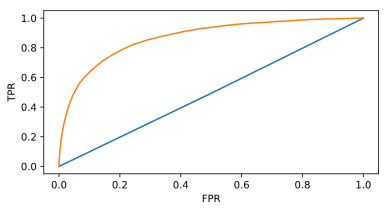

In [217]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y, np.random.randint(0, 2, size=len(y)))
plt.plot(fpr, tpr); 
fpr, tpr, thresholds = roc_curve(y, rf.predict_proba(x)[:, 1])
plt.plot(fpr, tpr); 
plt.xlabel('FPR'); plt.ylabel('TPR');
from sklearn.metrics import roc_auc_score
roc_auc_score(y, rf.predict_proba(x)[:, 1])

### Порог классификации

- Любая отсечка TPR или FPR дает порог
- Возьмем отсечку, которая дает 80% TPR

In [218]:
threshold = thresholds[np.where(tpr < 0.8)[0][-1]]
threshold, rf.predict_proba(x)[:, 1] > threshold

(0.06063186080030771, array([ True,  True,  True, ..., False, False, False]))

### Несбалансированные данные

- Downsample выборки и подбор порога с нужным TPR или FPR
- Использование весов примеров (предпочтительно)

### Параметрические модели

- Данные превращаются в модель с параметрами
- Модель с параметрами позволяет делать выводы (inference)
- Нормальное распределение: подбираем параметры, делаем выводы из математической модели

### Непараметрические модели

- Промежуточного представления нет
- Это не значит, что у модели нет гиперпараметров
- Бутстреппинг: берем данные, делаем выводы

### Метод ближайшего соседа

- И в случае классификации, и в случае регрессии используем тот label, что у ближайшего
- Неустойчив к шуму

In [219]:
np.sqrt(sum(df.iloc[0] - df.iloc[3])**2)
df.iloc[0] / sum(df.iloc[0])

SeriousDlqin2yrs                        0.000109
RevolvingUtilizationOfUnsecuredLines    0.000083
age                                     0.004896
NumberOfTime30-59DaysPastDueNotWorse    0.000218
DebtRatio                               0.000087
MonthlyIncome                           0.992271
NumberOfOpenCreditLinesAndLoans         0.001414
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000653
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.000218
Prediction                              0.000051
Name: 1, dtype: float64

### Метод k ближайших соседей

- Используем вместо одного соседа k ближайших
- В случае классификации делаем голосование большинством
- В случае регрессии усредняем
- Можно взвешивать с помощью расстояния

In [240]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(x, y)
knn.predict(x)

array([0, 0, 0, ..., 0, 0, 0])

### Быстрый поиск соседей

- Пространство можно поделить на части
- Почти любая реализация делает это
- Очень похоже на деревья решений

### Кластеризация

- Похожа на классификацию
- Но нет целевой функции
- Много разных способов измерения качества

### k-means

- Выбираем $k$ кластеров и случайно разбрасываем их центры
- Находим к какому кластеру отнести каждую точку
- Пересчитываем где должны быть кластеры: среднее всех точек, попавших в этот кластер

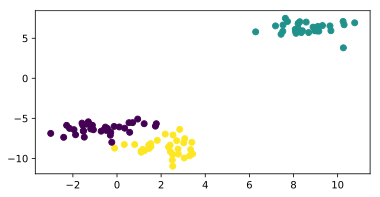

In [236]:
from sklearn.datasets import make_blobs
b = make_blobs(cluster_std=1.0)
from sklearn.cluster import MiniBatchKMeans
c = MiniBatchKMeans(n_clusters=3).fit_predict(b[0])
plt.scatter(b[0][:, 0], b[0][:, 1], c=c)

### Домашнее задание

- Поизображаем сервис с машинным обучением
- Обучить модель и запустить веб-сервер с работающей моделью
- В другом ноутбуке использовать эту модель

### В следующий раз

- Нейронные сети
- Завершение курса